<a href="https://colab.research.google.com/github/panik-79/deep-learning-lab/blob/main/chapter_recurrent-modern/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

[**The actual model**] is defined as described above,
consisting of three gates and an input node.
Note that only the hidden state is passed to the output layer.


In [4]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

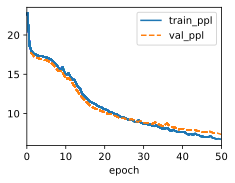

In [5]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [6]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

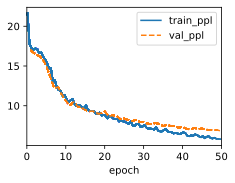

In [7]:
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [10]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and the fime the fi'

# LSTM for Image Processing

In [11]:
pip install torch torchvision


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [13]:
class ImageLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ImageLSTM, self).__init__()
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)

        out, _ = self.lstm(x, (h_0, c_0))

        # Take the output from the last time step
        out = out[:, -1, :]  # Get the last output from LSTM

        # Pass it through the fully connected layer
        out = self.fc(out)
        return out


In [14]:
# Transformations: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load training dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Download and load test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 38732728.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1454926.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9475770.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2521245.20it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [15]:
# Hyperparameters
sequence_length = 28  # Each image is 28x28 pixels
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10  # Digits 0-9 for MNIST
learning_rate = 0.001
num_epochs = 5

model = ImageLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/5], Step [100/938], Loss: 0.7306
Epoch [1/5], Step [200/938], Loss: 0.3645
Epoch [1/5], Step [300/938], Loss: 0.2889
Epoch [1/5], Step [400/938], Loss: 0.2396
Epoch [1/5], Step [500/938], Loss: 0.2232
Epoch [1/5], Step [600/938], Loss: 0.1196
Epoch [1/5], Step [700/938], Loss: 0.2344
Epoch [1/5], Step [800/938], Loss: 0.2829
Epoch [1/5], Step [900/938], Loss: 0.0369
Epoch [2/5], Step [100/938], Loss: 0.0685
Epoch [2/5], Step [200/938], Loss: 0.1351
Epoch [2/5], Step [300/938], Loss: 0.1590
Epoch [2/5], Step [400/938], Loss: 0.2103
Epoch [2/5], Step [500/938], Loss: 0.0621
Epoch [2/5], Step [600/938], Loss: 0.0215
Epoch [2/5], Step [700/938], Loss: 0.1346
Epoch [2/5], Step [800/938], Loss: 0.1912
Epoch [2/5], Step [900/938], Loss: 0.0123
Epoch [3/5], Step [100/938], Loss: 0.0275
Epoch [3/5], Step [200/938], Loss: 0.1544
Epoch [3/5], Step [300/938], Loss: 0.0072
Epoch [3/5], Step [400/938], Loss: 0.0442
Epoch [3/5], Step [500/938], Loss: 0.1106
Epoch [3/5], Step [600/938], Loss:

In [16]:
# Testing
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')


Accuracy of the model on the 10000 test images: 98.74%
